#**2020 US Election tweets analysis**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# stopwords, tokenizer, stemmer
import nltk  
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

# spell correction, lemmatization
from textblob import TextBlob
from textblob import Word

In [4]:
from PIL import Image
import plotly.express as px

In [5]:
trump_df = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')
biden_df = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')

In [6]:
trump_df['tweet'].head(10)

0    #Elecciones2020 | En #Florida: #JoeBiden dice ...
1    Usa 2020, Trump contro Facebook e Twitter: cop...
2    #Trump: As a student I used to hear for years,...
3    2 hours since last tweet from #Trump! Maybe he...
4    You get a tie! And you get a tie! #Trump ‘s ra...
5    @CLady62 Her 15 minutes were over long time ag...
6    @richardmarx Glad u got out of the house! DICK...
7    @DeeviousDenise @realDonaldTrump @nypost There...
8    One of the single most effective remedies to e...
9    #Election2020 #Trump \n#FreedomOfSpeech https:...
Name: tweet, dtype: object

In [ ]:
biden_df['tweet'].head(10)

0    #Elecciones2020 | En #Florida: #JoeBiden dice ...
1    #HunterBiden #HunterBidenEmails #JoeBiden #Joe...
2    @IslandGirlPRV @BradBeauregardJ @MeidasTouch T...
3    @chrislongview Watching and setting dvr. Let’s...
4    #censorship #HunterBiden #Biden #BidenEmails #...
5    "IS THIS WRONG??!!" Cory Booker's BRILLIANT Fi...
6    In 2020, #NYPost is being #censorship #CENSORE...
7    ►► Tell Politicians to STICK IT with this FREE...
8                       #Biden https://t.co/qMs0PmUev5
9    Proof  Bidens are crooked. Twitter will suspen...
Name: tweet, dtype: object

In [7]:
trump_df = trump_df.drop(columns=['tweet_id','user_id','user_name','user_screen_name',
                                  'user_description','user_join_date','collected_at','created_at','source','lat','long','state_code'])
biden_df = biden_df.drop(columns=['tweet_id','user_id','user_name','user_screen_name',
                                  'user_description','user_join_date','collected_at','created_at','source','lat','long','state_code'])

# Renaming columns
trump_df = trump_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets", 
                                    "state": "State", "user_followers_count": "Followers"})
biden_df = biden_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets", 
                                    "state": "State", "user_followers_count": "Followers"})

# Update United States country name for consistency
d = {"United States of America":"United States"}
trump_df['country'].replace(d, inplace=True)
biden_df['country'].replace(d, inplace=True)

trump_df = trump_df.loc[trump_df['country'] == "United States"]
biden_df = biden_df.loc[biden_df['country'] == "United States"]

# Drop null rows
trump_df = trump_df.dropna()
biden_df = biden_df.dropna()

In [ ]:
trump_df

,tweet,Likes,Retweets,Followers,user_location,city,country,continent,State
2,"#Trump: As a student I used to hear for years,...",2.0,1.0,1185.0,Portland,Portland,United States,North America,Oregon
4,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,5393.0,Washington DC,Washington,United States,North America,District of Columbia
11,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,1396.0,"Chicago, Illinois",Chicago,United States,North America,Illinois
12,#Trump #PresidentTrump #Trump2020LandslideVict...,3.0,5.0,496.0,"San Diego, CA",San Diego,United States,North America,California
22,"#Trump: Nobody likes to tell you this, but som...",1.0,1.0,1185.0,Portland,Portland,United States,North America,Oregon
...,...,...,...,...,...,...,...,...,...
970879,@realDonaldTrump @marklevinshow NO #Hoax! The ...,0.0,0.0,48.0,"Chicago, USA",Chicago,United States,North America,Illinois
970881,"@RBReich Bob,\nit's pretty straight forward.\n...",6.0,1.0,425.0,"oakland, california",Oakland,United States,North America,California
970888,"@Jim_Jordan FCK NO , Democrats and the #msm la...",1.0,0.0,1549.0,"New York, USA",New York,United States,North America,New York
970890,Cómo pasó el abogado de Trump de un hotel a un...,0.0,1.0,1517.0,New York City,New York,United States,North America,New York


In [ ]:
biden_df

,tweet,Likes,Retweets,Followers,user_location,city,country,continent,State
6,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,1397.0,"Chicago, Illinois",Chicago,United States,North America,Illinois
17,"Comments on this? ""Do Democrats Understand how...",0.0,0.0,83.0,"Tampa, Florida",Tampa,United States,North America,Florida
22,Twitter is doing everything they can to help D...,1.0,0.0,2.0,"Hollywood, FL",Los Angeles,United States,North America,California
25,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,0.0,0.0,29.0,"Los Angeles, CA",Los Angeles,United States,North America,California
29,Come on @ABC PLEASE DO THE RIGHT THING. Move t...,0.0,0.0,166.0,"New York, NY",New York,United States,North America,New York
...,...,...,...,...,...,...,...,...,...
776836,"#Biden 🗽🇺🇸👍🏽 | Images 📷 @ Santa Maria, CA. | ...",1.0,0.0,8881.0,LOS ANGELES,Los Angeles,United States,North America,California
776845,Will #criticalRaceTheory become ubiquitous in ...,0.0,0.0,12606.0,"Philadelphia, PA",Philadelphia,United States,North America,Pennsylvania
776847,You moving near #Biden 🤔 https://t.co/1F6i1YIJ2P,0.0,0.0,803.0,Philadelphia PA,Philadelphia,United States,North America,Pennsylvania
776861,#election #2020Elections #trump #biden https:/...,0.0,0.0,1092.0,"New York, USA",New York,United States,North America,New York


In [8]:
to_remove = r'\d+|http?\S+|[^A-Za-z0-9]+'
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Function to preprocess tweet 
def clean_tweet(tweet, stem=False, lemmatize=False):

    # Make all text lowercase
    tweet = tweet.lower()
    
    # Remove links, special characters, punctuation, numbers, etc.
    tweet = re.sub(to_remove, ' ', tweet)
        
    filtered_tweet = []
    words = word_tokenize(tweet) 

    # Remove stopwords and stem
    for word in words:
        if not word in stop_words:
            if stem:
                filtered_tweet.append(ps.stem(word))
            elif lemmatize:
                filtered_tweet.append(Word(word).lemmatize())
            else:
                filtered_tweet.append(word)
            
    return filtered_tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
trump_df['tweet'] = trump_df.tweet.apply(lambda x: clean_tweet(x))
biden_df['tweet'] = biden_df.tweet.apply(lambda x: clean_tweet(x))

In [10]:
def sentiment_analysis_Trump_df(df):
    
    # Determine polarity and subjectivity
    df['Polarity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)
    
    # Classify overall sentiment
    df.loc[df.Polarity > 0,'Sentiment'] = 'EVT'#Expected Vote for Trump
    df.loc[df.Polarity == 0,'Sentiment'] = 'ENV'#Expected No Vote for Either candidates
    df.loc[df.Polarity < 0,'Sentiment'] = 'EVB'#Expected Vote for Biden
    
    return df

In [11]:
trump_df=sentiment_analysis_Trump_df(trump_df)

In [12]:
trump_df=trump_df.reset_index()


In [13]:
trump_df=trump_df.drop(columns=['index'])
trump_df

,tweet,Likes,Retweets,Followers,user_location,city,country,continent,State,Polarity,Subjectivity,Sentiment
0,"[trump, student, used, hear, years, ten, years...",2.0,1.0,1185.0,Portland,Portland,United States,North America,Oregon,0.333333,0.333333,EVT
1,"[get, tie, get, tie, trump, rally, iowa]",4.0,3.0,5393.0,Washington DC,Washington,United States,North America,District of Columbia,0.000000,0.000000,ENV
2,"[nypost, censorship, censored, twitter, manipu...",0.0,0.0,1396.0,"Chicago, Illinois",Chicago,United States,North America,Illinois,-0.148810,0.678571,EVB
3,"[trump, presidenttrump, trump, landslidevictor...",3.0,5.0,496.0,"San Diego, CA",San Diego,United States,North America,California,0.500000,0.750000,EVT
4,"[trump, nobody, likes, tell, farmers, better, ...",1.0,1.0,1185.0,Portland,Portland,United States,North America,Oregon,0.261905,0.595238,EVT
...,...,...,...,...,...,...,...,...,...,...,...,...
101962,"[realdonaldtrump, marklevinshow, hoax, america...",0.0,0.0,48.0,"Chicago, USA",Chicago,United States,North America,Illinois,0.000000,0.000000,ENV
101963,"[rbreich, bob, pretty, straight, forward, trum...",6.0,1.0,425.0,"oakland, california",Oakland,United States,North America,California,0.225000,0.700000,EVT
101964,"[jim, jordan, fck, democrats, msm, launched, h...",1.0,0.0,1549.0,"New York, USA",New York,United States,North America,New York,0.000000,0.000000,ENV
101965,"[c, mo, pas, el, abogado, de, trump, de, un, h...",0.0,1.0,1517.0,New York City,New York,United States,North America,New York,0.000000,0.000000,ENV


In [14]:
def sentiment_analysis_biden_df(df):
    
    # Determine polarity and subjectivity
    df['Polarity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)
    
    # Classify overall sentiment
    df.loc[df.Polarity > 0,'Sentiment'] = 'EVB'#Expected Vote for Biden
    df.loc[df.Polarity == 0,'Sentiment'] = 'ENV'#Expected No Vote for Either candidates
    df.loc[df.Polarity < 0,'Sentiment'] = 'EVT'#Expected Vote for Trump
    
    return df

In [15]:
biden_df=sentiment_analysis_biden_df(biden_df)

In [16]:
biden_df=biden_df.reset_index()

In [17]:
biden_df=biden_df.drop(columns=['index'])
biden_df

,tweet,Likes,Retweets,Followers,user_location,city,country,continent,State,Polarity,Subjectivity,Sentiment
0,"[nypost, censorship, censored, twitter, manipu...",0.0,0.0,1397.0,"Chicago, Illinois",Chicago,United States,North America,Illinois,-0.148810,0.678571,EVT
1,"[comments, democrats, understand, ruthless, ch...",0.0,0.0,83.0,"Tampa, Florida",Tampa,United States,North America,Florida,-1.000000,1.000000,EVT
2,"[twitter, everything, help, democrats, win, el...",1.0,0.0,2.0,"Hollywood, FL",Los Angeles,United States,North America,California,0.175000,0.522222,EVB
3,"[realjameswoods, bidencrimefamily, joebiden, h...",0.0,0.0,29.0,"Los Angeles, CA",Los Angeles,United States,North America,California,0.000000,0.000000,ENV
4,"[come, abc, please, right, thing, move, biden,...",0.0,0.0,166.0,"New York, NY",New York,United States,North America,New York,0.078571,0.178571,EVB
...,...,...,...,...,...,...,...,...,...,...,...,...
90637,"[biden, images, santa, maria, ca, wethepeopleh...",1.0,0.0,8881.0,LOS ANGELES,Los Angeles,United States,North America,California,0.000000,0.000000,ENV
90638,"[criticalracetheory, become, ubiquitous, biden...",0.0,0.0,12606.0,"Philadelphia, PA",Philadelphia,United States,North America,Pennsylvania,0.000000,0.000000,ENV
90639,"[moving, near, biden]",0.0,0.0,803.0,Philadelphia PA,Philadelphia,United States,North America,Pennsylvania,0.100000,0.400000,EVB
90640,"[election, elections, trump, biden]",0.0,0.0,1092.0,"New York, USA",New York,United States,North America,New York,0.000000,0.000000,ENV


Trump Tweet Sentiment Breakdown


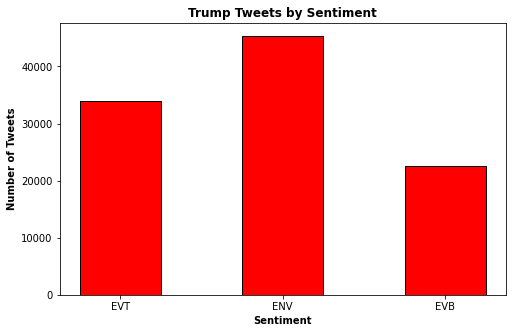

In [18]:
print("Trump Tweet Sentiment Breakdown")

trump_positive = len(trump_df.loc[trump_df.Sentiment=='EVT'])
trump_neutral = len(trump_df.loc[trump_df.Sentiment=='ENV'])
trump_negative = len(trump_df.loc[trump_df.Sentiment=='EVB'])

# Graphing the number of trump tweets by sentiment
data_t = {'EVT':trump_positive,'ENV':trump_neutral,'EVB':trump_negative}
sentiment_t = list(data_t.keys()) 
num_tweets_t = list(data_t.values()) 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_t, num_tweets_t, color ='red', width = 0.5, edgecolor='black',) 

plt.xlabel("Sentiment", fontweight ='bold') 
plt.ylabel("Number of Tweets", fontweight ='bold') 
plt.title("Trump Tweets by Sentiment", fontweight ='bold') 
plt.show() 

Biden Tweet Sentiment Breakdown


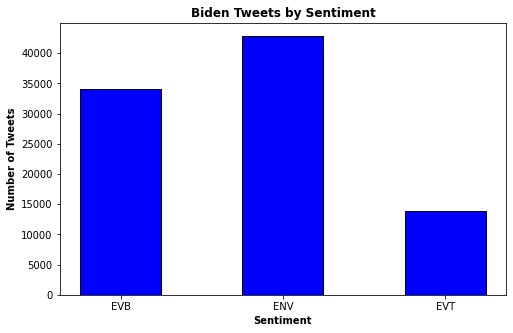

In [ ]:
print("Biden Tweet Sentiment Breakdown")

biden_positive = len(biden_df.loc[biden_df.Sentiment=='EVB'])
biden_neutral = len(biden_df.loc[biden_df.Sentiment=='ENV'])
biden_negative = len(biden_df.loc[biden_df.Sentiment=='EVT'])

# Graphing the number of biden tweets by sentiment
data_b = {'EVB':biden_positive,'ENV':biden_neutral,'EVT':biden_negative}
sentiment_b = list(data_b.keys()) 
num_tweets_b = list(data_b.values()) 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_b, num_tweets_b, color ='blue', width = 0.5, edgecolor='black') 

plt.xlabel("Sentiment", fontweight ='bold') 
plt.ylabel("Number of Tweets", fontweight ='bold') 
plt.title("Biden Tweets by Sentiment", fontweight ='bold') 
plt.show() 

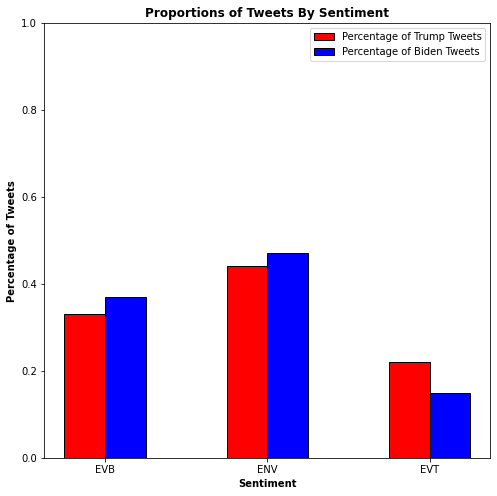

In [ ]:
total_tweets_t = len(trump_df.Sentiment)
prop_tweets_t = list(map(lambda x: round(x/total_tweets_t,2), num_tweets_t))

# Calculate relative percentages by sentiment - Biden
total_tweets_b = len(biden_df.Sentiment)
prop_tweets_b = list(map(lambda x: round(x/total_tweets_b,2), num_tweets_b))

# Graphing relative percentages of both trump and biden tweets
bar_width = 0.25
plt.subplots(figsize=(8,8))

br1 = np.arange(3) 
br2 = [x + bar_width for x in br1] 

t = plt.bar(br1, prop_tweets_t, color ='r', width = bar_width, 
            edgecolor ='black', label ='Trump') 
b = plt.bar(br2, prop_tweets_b, color ='b', width = bar_width, 
            edgecolor ='black', label ='Biden') 
   
plt.xlabel('Sentiment',fontweight ='bold') 
plt.ylabel('Percentage of Tweets',fontweight ='bold') 
plt.xticks([r + bar_width/2 for r in range(3)],['EVB','ENV','EVT'])
plt.legend([t,b],['Percentage of Trump Tweets','Percentage of Biden Tweets'])
plt.ylim(0.0, 1.0)
plt.title('Proportions of Tweets By Sentiment',fontweight ='bold')
plt.show()


In [ ]:
trump_state_polarity = trump_df.groupby("State",as_index=False).mean()

fig = px.bar(trump_state_polarity, x="State", y="Polarity",
            title="<b>Average Polarity of Trump-Related Tweets by State</b>")
fig.update_traces(marker=dict(color="red"),selector=dict(type="bar"),
                  marker_line_color='black', marker_line_width=0.8, opacity=0.6)
fig.show()

In [ ]:
biden_state_polarity = biden_df.groupby("State",as_index=False).mean()

fig = px.bar(biden_state_polarity, x="State", y="Polarity",
            title="<b>Average Polarity of Biden-Related Tweets by State</b>")
fig.update_traces(marker=dict(color="blue"),selector=dict(type="bar"),
                  marker_line_color='black', marker_line_width=0.8, opacity=0.6)
fig.show()

In [19]:
frames=[biden_df,trump_df]
df = pd.concat(frames)
df=df.drop(columns=['Likes','Retweets','Followers','city','country','continent','State','Subjectivity','Polarity','user_location'])
df

,tweet,Sentiment
0,"[nypost, censorship, censored, twitter, manipu...",EVT
1,"[comments, democrats, understand, ruthless, ch...",EVT
2,"[twitter, everything, help, democrats, win, el...",EVB
3,"[realjameswoods, bidencrimefamily, joebiden, h...",ENV
4,"[come, abc, please, right, thing, move, biden,...",EVB
...,...,...
101962,"[realdonaldtrump, marklevinshow, hoax, america...",ENV
101963,"[rbreich, bob, pretty, straight, forward, trum...",EVT
101964,"[jim, jordan, fck, democrats, msm, launched, h...",ENV
101965,"[c, mo, pas, el, abogado, de, trump, de, un, h...",ENV


In [20]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['Sentiment']=le.fit_transform(df['Sentiment'])


In [21]:
df

,tweet,Sentiment
0,"[nypost, censorship, censored, twitter, manipu...",2
1,"[comments, democrats, understand, ruthless, ch...",2
2,"[twitter, everything, help, democrats, win, el...",1
3,"[realjameswoods, bidencrimefamily, joebiden, h...",0
4,"[come, abc, please, right, thing, move, biden,...",1
...,...,...
101962,"[realdonaldtrump, marklevinshow, hoax, america...",0
101963,"[rbreich, bob, pretty, straight, forward, trum...",2
101964,"[jim, jordan, fck, democrats, msm, launched, h...",0
101965,"[c, mo, pas, el, abogado, de, trump, de, un, h...",0


In [22]:
stemmer=PorterStemmer()
def word_stemmer(text):
  stem_text=" ".join([stemmer.stem(i) for i in text])
  return stem_text

In [23]:
df['tweet']=df['tweet'].apply(lambda x:word_stemmer(x))

In [ ]:
df

,tweet,Sentiment
0,nypost censorship censor twitter manipul us el...,2
1,comment democrat understand ruthless china chi...,2
2,twitter everyth help democrat win elect make s...,1
3,realjameswood bidencrimefamili joebiden hunter...,0
4,come abc pleas right thing move biden town hal...,1
...,...,...
101962,realdonaldtrump marklevinshow hoax american pe...,0
101963,rbreich bob pretti straight forward trump conc...,2
101964,jim jordan fck democrat msm launch hr attack p...,0
101965,c mo pa el abogado de trump de un hotel un apa...,0


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 100)
X = cv.fit_transform(df['tweet']).toarray()
y=df.iloc[:,-1].values

In [25]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [26]:
print(X.shape, y.shape)

(192609, 100) (192609,)


In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

**Structuring Multilayer Perceptron (MLP)  Auto Encoder model**

In [28]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
n_inputs=100

**Encoder Layout**

In [ ]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

**Decoder Layout**

In [ ]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='mse')

**Strucuture of Autoencoder**

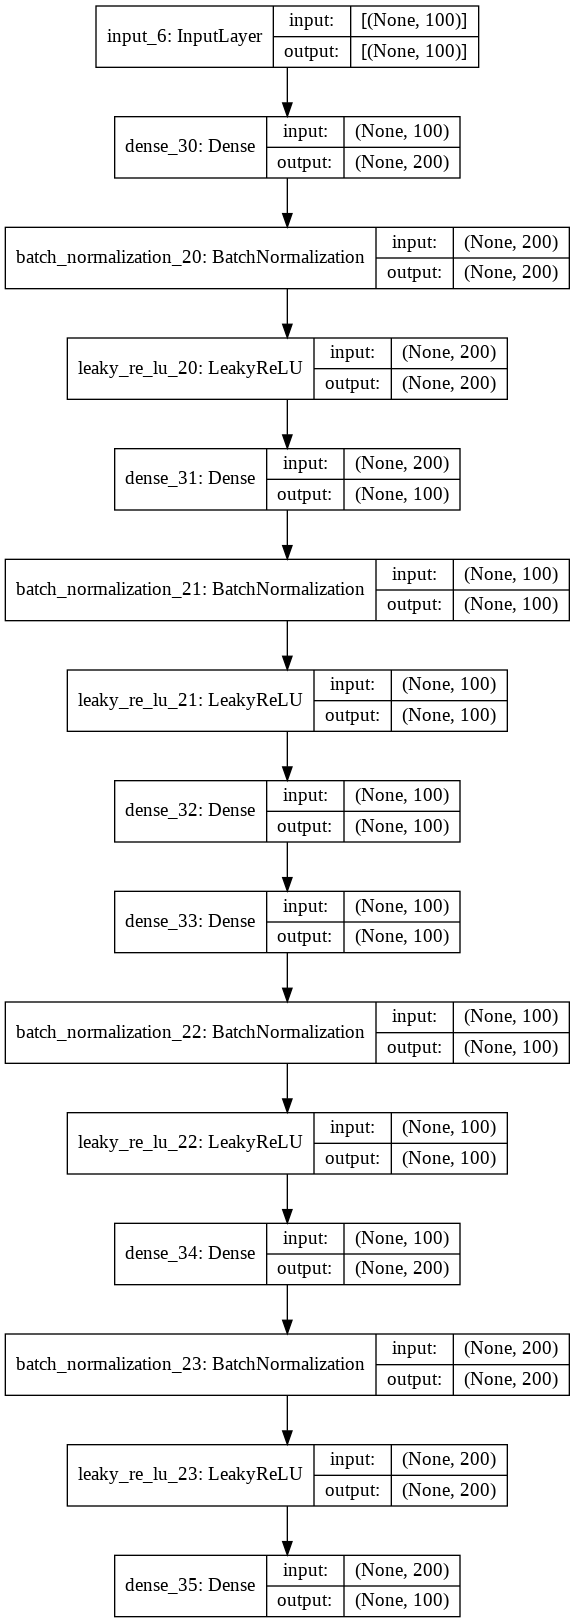

In [ ]:
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=20000, verbose=2, validation_data=(X_test,y_test))


Epoch 1/500
8/8 - 3s - loss: 0.6942 - val_loss: 1.0552
Epoch 2/500
8/8 - 3s - loss: 0.5973 - val_loss: 1.0243
Epoch 3/500
8/8 - 3s - loss: 0.5591 - val_loss: 0.9871
Epoch 4/500
8/8 - 3s - loss: 0.5387 - val_loss: 0.9322
Epoch 5/500
8/8 - 3s - loss: 0.5253 - val_loss: 0.8715
Epoch 6/500
8/8 - 3s - loss: 0.5164 - val_loss: 0.8209
Epoch 7/500
8/8 - 3s - loss: 0.5097 - val_loss: 0.7787
Epoch 8/500
8/8 - 3s - loss: 0.5046 - val_loss: 0.7313
Epoch 9/500
8/8 - 3s - loss: 0.5007 - val_loss: 0.6938
Epoch 10/500
8/8 - 3s - loss: 0.4974 - val_loss: 0.6575
Epoch 11/500
8/8 - 3s - loss: 0.4941 - val_loss: 0.6369
Epoch 12/500
8/8 - 3s - loss: 0.4913 - val_loss: 0.6142
Epoch 13/500
8/8 - 3s - loss: 0.4887 - val_loss: 0.5909
Epoch 14/500
8/8 - 3s - loss: 0.4863 - val_loss: 0.5718
Epoch 15/500
8/8 - 3s - loss: 0.4840 - val_loss: 0.5522
Epoch 16/500
8/8 - 3s - loss: 0.4827 - val_loss: 0.5426
Epoch 17/500
8/8 - 3s - loss: 0.4807 - val_loss: 0.5325
Epoch 18/500
8/8 - 3s - loss: 0.4789 - val_loss: 0.5232
E

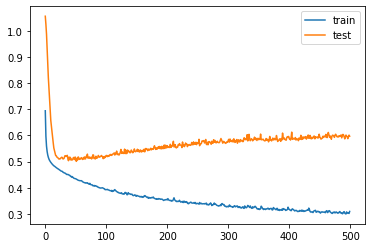

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('USVA-encoder.h5')

In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model


In [30]:
encoder = load_model('USVA-encoder.h5')
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

In [32]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier(alpha=0.01, batch_size=2560, epsilon=1e-08,learning_rate='adaptive', max_iter=1000)
model.fit(X_train_encode,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=2560, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [33]:
res = model.predict(X_test_encode)
res=np.round(res)
np.set_printoptions(precision=2)
print(res)

from sklearn.metrics import accuracy_score
print("Accuracy Score for the algorithm=>{}%".format(round(accuracy_score(y_test,res)*100),2))

[2 0 0 ... 0 0 2]
Accuracy Score for the algorithm=>59%
